On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.cross_decomposition import PLSRegression

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [4]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [5]:
%run Regression_GAM_Gamma.py

# Val croisée

In [6]:
n_knots = 10
max_compo = 100
max_lag = 7

for curr_compo in tqdm(range(1, max_compo+1)):
    for curr_lag in range(max_lag+1):
        
        cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})

        cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
        
        for curr_split in range(9):

            # Entraintement
            curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
            curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
                #Standardisation Train_X
            curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
            for code in liste_stations_debit:
                curr_train_X_mean[code] = 0
            curr_train_X_std = curr_train_X[liste_stations_debit].std()
            curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
            curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_train_X_standard["Date"] = curr_train_X["Date"]
                #GAM
            spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
            curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                                   curr_train_X_standard, 
                                                                                   liste_stations_debit)
            curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, 
                                                      curr_train_X_standard[colonnes_meteo_stations]],
                                                     axis = 1)
            # Ajout AR
            colonnes_reg = colonnes_meteo_stations
            for i in range(curr_lag+1):
                variable = curr_train_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, variable], axis = 1)
                colonnes_reg = colonnes_reg + [code+"_"+str(i) for code in liste_stations_debit]
                
            # PLS
            curr_train_X_standard_residus = curr_train_X_standard_residus[(7+curr_lag):]
            model_PLS = PLSRegression(n_components=curr_compo)
            model_PLS.fit(X = curr_train_X_standard_residus[colonnes_reg],
                          Y = curr_train_X_standard_residus[liste_stations_debit])
            
            # Predictions GAM
            curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
            curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
            liste_dates = curr_test_Y["Date"]
                # Test_X standard
            curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                                  curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_test_X_standard["Date"] = curr_test_X["Date"].values
            curr_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit,
                                                                              curr_test_X_standard, 
                                                                              liste_stations_debit)
            curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, 
                                                      curr_test_X_standard[colonnes_meteo_stations]],
                                                     axis = 1)
                # Ajout variables AR
            for i in range(curr_lag+1):
                variable = curr_test_X_standard_residus[liste_stations_debit].shift(i+7)
                variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, variable], axis = 1)

                # Pred PLS
            curr_test_X_standard_residus = curr_test_X_standard_residus[(7+curr_lag):]
            predictions_test_Y_standard_residus = model_PLS.predict(curr_test_X_standard_residus[colonnes_reg])
            predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
            predictions_test_Y_standard_residus["Date"] = curr_test_X_standard_residus["Date"].values

            # Filtre sur les dates
            resultat = pd.DataFrame()
            for curr_date in liste_dates:
                resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
            resultat = resultat.sort_values(by = "Date")
            predictions_test_Y_standard_residus = resultat.copy()

            # On rajoute la compo saisonnalité
            predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
            predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
            for code in liste_stations_debit:
                predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values

            # Score standard
            curr_test_Y_standard = fct_Standardize(curr_test_Y, 
                                                   curr_train_X_mean, curr_train_X_std, 
                                                   liste_stations_debit)
            curr_test_Y_standard["Date"] = curr_test_Y["Date"]
            curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]

            # Score
            predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                                   curr_train_X_mean, curr_train_X_std, liste_stations_debit)
            predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values
            curr_RMSE = fct_RMSE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]

        cv_moyen_RMSE_standard = []
        cv_moyen_MAE_standard = []
        cv_moyen_R2_standard = []

        cv_moyen_RMSE = []
        cv_moyen_MAE = []
        cv_moyen_R2 = []

        for code in liste_stations_debit:
            score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE_standard.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE_standard.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2_standard.append(score_R2)
            score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2.append(score_R2)

        cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
        cv_scores_RMSE_standard.to_csv("../Data/GAMPLSAR/CV_RMSE_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
        cv_scores_MAE_standard.to_csv("../Data/GAMPLSAR/CV_MAE_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
        cv_scores_R2_standard.to_csv("../Data/GAMPLSAR/CV_R2_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
        cv_scores_RMSE.to_csv("../Data/GAMPLSAR/CV_RMSE_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_MAE["Moyenne"] = cv_moyen_MAE
        cv_scores_MAE.to_csv("../Data/GAMPLSAR/CV_MAE_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)
        cv_scores_R2["Moyenne"] = cv_moyen_R2
        cv_scores_R2.to_csv("../Data/GAMPLSAR/CV_R2_" + str(curr_compo) + "_" + str(curr_lag) + ".csv",
                              index=False)    

100%|██████████| 100/100 [20:02:24<00:00, 721.45s/it]    


## Selection

## Moyen

In [11]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMPLSAR/CV_RMSE_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["N_Compo"] = curr_compo
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

In [ ]:
plt.plot(cv_moyen["N_Compo"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

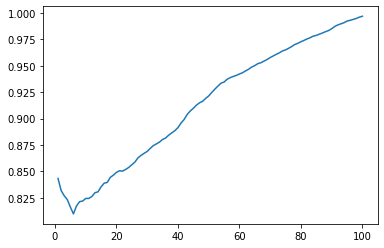

In [30]:
plt.plot(cv_moyen.groupby("N_Compo").mean().index, cv_moyen.groupby("N_Compo").mean()[liste_stations_debit].mean(axis = 1).values)

In [33]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    for curr_lag in range(max_lag+1):
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMPLSAR/CV_R2_standard_" + str(curr_compo) + "_" + str(curr_lag) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["N_Compo"] = curr_compo
        curr_moyen["Lags"] = curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

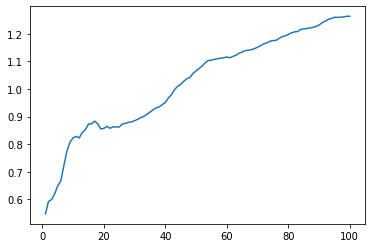

In [34]:
plt.plot(cv_moyen.groupby("N_Compo").mean().index, cv_moyen.groupby("N_Compo").mean()[liste_stations_debit].mean(axis = 1).values)

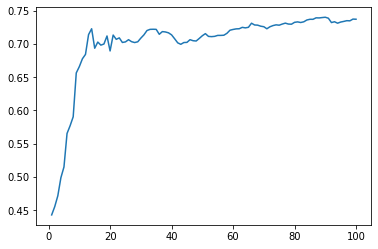

In [22]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMPLS_Meteo/CV_R2_standard_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["N_Compo"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

In [23]:
cv_moyen[liste_stations_debit].mean(axis = 1).values

array([0.44267134, 0.45515175, 0.47145157, 0.49864496, 0.51485831,
       0.56527876, 0.57690016, 0.59036548, 0.65635855, 0.66589435,
       0.67767078, 0.68426563, 0.71404702, 0.72286391, 0.69353666,
       0.70279516, 0.69819675, 0.69990178, 0.71198189, 0.68944924,
       0.71335105, 0.70693879, 0.70909422, 0.70221962, 0.70307586,
       0.70637738, 0.70338952, 0.7020967 , 0.70323766, 0.7087332 ,
       0.71361644, 0.72016779, 0.72193676, 0.72210052, 0.72193217,
       0.71451113, 0.7185656 , 0.71803364, 0.71672856, 0.71367791,
       0.70777283, 0.70166473, 0.6994445 , 0.70212014, 0.70233668,
       0.70641021, 0.70484883, 0.70439472, 0.70824323, 0.71232832,
       0.71551037, 0.71134777, 0.71099048, 0.71140416, 0.71283929,
       0.7128465 , 0.71309873, 0.71595988, 0.72065798, 0.72178831,
       0.72265072, 0.72285855, 0.72497143, 0.72418691, 0.72503677,
       0.73119506, 0.72854392, 0.72827941, 0.72669403, 0.72593271,
       0.72283099, 0.72584314, 0.72762392, 0.72873578, 0.72820

# Test

In [24]:
n_compo = 15

In [26]:
# Entraintement
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
for code in liste_stations_debit:
    mesures_train_X_mean[code] = 0
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]

In [27]:
spline_fit = fct_Regression_SplineGamma_fit(mesures_train_X_standard, liste_stations_debit, n_knots)
mesures_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                      mesures_train_X_standard, 
                                                                               liste_stations_debit)
model_PLS = PLSRegression(n_components=n_compo)
model_PLS.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
              Y = mesures_train_X_standard_residus[liste_stations_debit])

PLSRegression(n_components=15)

In [28]:
liste_dates = mesures_test_Y["Date"]
            # Test_X standard
mesures_test_X_standard =fct_Standardize(mesures_test_X, 
                                         mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values

In [31]:
# Pred
predictions_test_Y_standard_residus = model_PLS.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
predictions_test_Y_standard_residus["Date"] = mesures_test_X_standard["Date"].values
# Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard_residus = resultat.copy()

In [32]:
# On rajoute la compo saisonnalité
predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
for code in liste_stations_debit:
    predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values

In [34]:
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

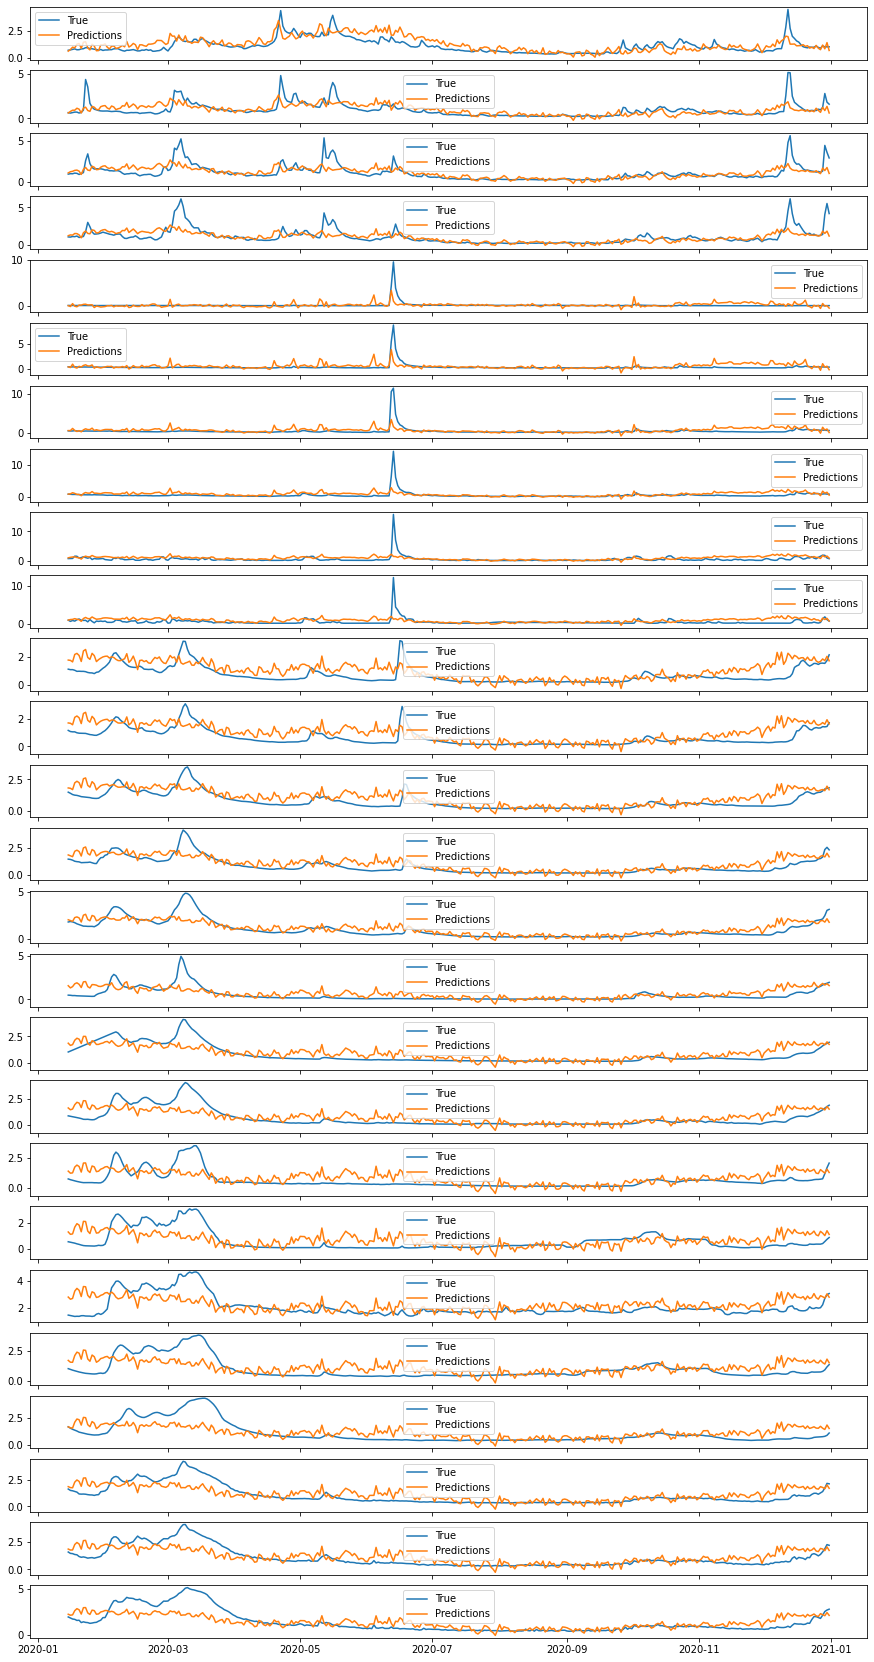

In [37]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    #axs[i].plot(predictions_test_Y_standard_saisonnalite["Date"], predictions_test_Y_standard_saisonnalite[code], label = "Saisonnalite")
    #axs[i].plot(predictions_test_Y_standard_residus["Date"], predictions_test_Y_standard_residus[code], label = "Residus")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [39]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard.to_csv("../Data/GAMPLS_Meteo/Test_scores_standard.csv",
                   index = False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.524034,0.398408,1.001717
1,O2620010,0.655485,0.434267,0.478755
2,O6140010,0.719014,0.449684,0.419779
3,O9000010,0.788788,0.471909,0.367784
4,K0030020,0.630590,0.296058,0.435641
5,K0100020,0.672197,0.377719,0.561942
6,K0260020,0.905527,0.477448,0.321995
7,K0550010,1.002111,0.561264,0.317545
8,K0690010,1.088385,0.616704,0.254509
9,K0910050,0.939106,0.600853,0.304631


In [40]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.721683
MAE     0.488331
R2      0.508622
dtype: float64

In [42]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                            mesures_train_X_mean, mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

In [44]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores.to_csv("../Data/GAMPLS_Meteo/Test_scores.csv",
                   index = False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,24.326523,18.494748,1.001717
1,O2620010,129.926303,86.077881,0.478755
2,O6140010,236.585134,147.964503,0.419779
3,O9000010,383.520853,229.449185,0.367784
4,K0030020,3.867138,1.815600,0.435641
5,K0100020,6.329298,3.556543,0.561942
6,K0260020,16.774423,8.844486,0.321995
7,K0550010,36.509347,20.448225,0.317545
8,K0690010,48.690614,27.589208,0.254509
9,K0910050,54.226322,34.694731,0.304631
